# Learning about Kalman filter / Extended Kalman Filter Part 2

**Resources**

`Kalman Filter from Ground Up`; author Alex Becker; https://www.kalmanfilter.net

**Overview**

A worked example of object tracking with the `EKF`-filter.

This notebook reproduces example 11 of chapter 13.7 `vehicle location estimation using radar` with some additional annotations.


---

A car moves in a 2D grid where the state extrapolation equations are given by:

$$
\hat{\mathbf{x}}_{n+1,n} = \mathbf{F} \cdot \hat{\mathbf{x}}_{n,n}
$$

Here we are dealing with a linear system with no external inputs. The state vector has 6 components:

$$
\mathbf{x}_n = \left[\begin{array}{c}
x_n \\ \dot{x}_n \\ \ddot{x}_n \\
y_n \\ \dot{y}_n \\ \ddot{y}_n
\end{array}\right]
$$

**state extrapolation equation**

$$
\left[\begin{array}{c}
\hat{x}_{n+1,n} \\ \hat{\dot{x}}_{n+1,n} \\ \hat{\ddot{x}}_{n+1,n} \\
\hat{y}_{n+1,n} \\ \hat{\dot{y}}_{n+1,n} \\ \hat{\ddot{y}}_{n+1,n}
\end{array}\right] = \left[\begin{array}{cccccc}
1 & \Delta t & 0.5 \cdot \Delta t^2 & 0 & 0 & 0 \\
0 & 1 & \Delta t & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & \Delta t & 0.5 \cdot \Delta t^2 \\
0 & 0 & 0 & 0 & 1 & \Delta t \\
0 & 0 & 0 & 0 & 0 & 1 
\end{array}\right] \cdot
\left[\begin{array}{c}
\hat{x}_{n,n} \\ \hat{\dot{x}}_{n,n} \\ \hat{\ddot{x}}_{n,n} \\
\hat{y}_{n,n} \\ \hat{\dot{y}}_{n,n} \\ \hat{\ddot{y}}_{n,n}
\end{array}\right] 
$$

For the state transition matrix $\mathbf{F}$ we get:

$$
\mathbf{F} = \left[\begin{array}{cccccc}
1 & \Delta t & 0.5 \cdot \Delta t^2 & 0 & 0 & 0 \\
0 & 1 & \Delta t & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & \Delta t & 0.5 \cdot \Delta t^2 \\
0 & 0 & 0 & 0 & 1 & \Delta t \\
0 & 0 & 0 & 0 & 0 & 1 
\end{array}\right] 
$$

---

**covariance extrapolation equation**


$$
\mathbf{P_{n+1,n}} = \mathbf{F} \cdot \mathbf{P_{n,n}} \cdot \mathbf{F}^T  + \mathbf{Q}
$$

For the covariance matrix $\mathbf{P}$ the general structure is given by:

$$
\mathbf{P} = \left[\begin{array}{cccccc}
p_{x,x} & p_{x,\dot{x}} & p_{x,\ddot{x}} & 0 & 0 & 0 \\
p_{\dot{x},x} & p_{\dot{x},\dot{x}} & p_{\dot{x},\ddot{x}} & 0 & 0 & 0 \\
p_{\ddot{x},x} & p_{\ddot{x},\dot{x}} & p_{\ddot{x},\ddot{x}} & 0 & 0 & 0 \\
0 & 0 & 0 & p_{y,y} & p_{y,\dot{y}} & p_{y,\ddot{y}} \\
0 & 0 & 0 & p_{\dot{y},y} & p_{\dot{y},\dot{y}} & p_{\dot{y},\ddot{y}} \\
0 & 0 & 0 & p_{\ddot{y},y} & p_{\ddot{y},\dot{y}} & p_{\ddot{y},\ddot{y}}
\end{array}\right]
$$

**process noise**

We assume that in the constant acceleration model the acceleration is noisy and its variance is denoted $\sigma_a^2$. We define a square matrix $\mathbf{Q}_a$ by:

$$
\mathbf{Q}_a = \left[\begin{array}{cccccc}
0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 \\
\end{array}\right] \cdot \sigma_a^2
$$

The covariance matrix $\mathbf{Q}$ of process noise is computed from:

$$\begin{align}
\mathbf{Q} &= \mathbf{F} \cdot \mathbf{Q}_a \cdot \mathbf{F}^T \\
&= \left[\begin{array}{cccccc}
1 & \Delta t & 0.5 \cdot \Delta t^2 & 0 & 0 & 0 \\
0 & 1 & \Delta t & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & \Delta t & 0.5 \cdot \Delta t^2 \\
0 & 0 & 0 & 0 & 1 & \Delta t \\
0 & 0 & 0 & 0 & 0 & 1 
\end{array}\right] \cdot \left[\begin{array}{cccccc}
0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 \\
\end{array}\right] \cdot \left[\begin{array}{cccccc}
1 & 0 & 0 & 0 & 0 & 0 \\
\Delta t & 1 & 0 & 0 & 0 & 0 \\
0.5 \cdot \Delta t^2 & \Delta t & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & \Delta t & 1 & 0\\
0 & 0 & 0 & 0.5 \cdot \Delta t^2 & \Delta t & 1 
\end{array}\right] \cdot \sigma_a^2 \\
&= \left[\begin{array}{cccccc}
1 & \Delta t & 0.5 \cdot \Delta t^2 & 0 & 0 & 0 \\
0 & 1 & \Delta t & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & \Delta t & 0.5 \cdot \Delta t^2 \\
0 & 0 & 0 & 0 & 1 & \Delta t \\
0 & 0 & 0 & 0 & 0 & 1 
\end{array}\right] \cdot \left[\begin{array}{cccccc}
0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 \\
0.5 \cdot \Delta t^2  & \Delta t & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0.5 \cdot \Delta t^2  & \Delta t & 1\\
\end{array}\right] \cdot \sigma_a^2 \\
&= \left[\begin{array}{cccccc}
0.25 \cdot \Delta t^4  & 0.5 \cdot \Delta t^3  & 0.5 \cdot \Delta t^2 & 0 & 0 & 0 \\
0.5 \cdot \Delta t^3 & \Delta t^2 & \Delta t & 0 & 0 & 0 \\
0.5 \cdot \Delta t^2 & \Delta t & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0.25 \cdot \Delta t^4  & 0.5 \cdot \Delta t^3  & 0.5 \cdot \Delta t^2 \\
0 & 0 & 0 & 0.5 \cdot \Delta t^3 & \Delta t^2 & \Delta t \\
0 & 0 & 0 & 0.5 \cdot \Delta t^2 & \Delta t & 1
\end{array}\right] \cdot \sigma_a^2 
\end{align}
$$

**measurement equation**

With every time instant the distance $r_n$ of the object and the angle $\varphi_n$ are measured. The measurement vector $\mathbf{z}_n$ is then:

$$
\mathbf{z}_n = \left[\begin{array}{c}
r_n \\ \varphi_n
\end{array}\right]
$$

$$
r_n = \sqrt{x_n^2 + y_n^2}
$$

$$
\varphi_n = arctan\left( \frac{y_n}{x_n}\right)
$$

$$
\mathbf{z}_n = \left[\begin{array}{c}
r\\ \varphi 
\end{array}\right] = \left[\begin{array}{c}
\sqrt{x^2 + y^2} \\
 arctan\left( \frac{y}{x}\right)
\end{array}\right] = \left[\begin{array}{c}
r\\ \varphi 
\end{array}\right] = \left[\begin{array}{c}
h_1(x,y) \\
h_2(x,y)
\end{array}\right] = \mathbf{h}(x,y)
$$

Since the state vector and the measurement are nonlinearly related we need to calculate the `Jacobian`-matrix .

$$\begin{align}
\frac{\partial \mathbf{h}}{\partial ()} &= \left[\begin{array}{cccccc}
\frac{d h_1(x,y)}{dx} & \frac{d h_1(x,y)}{d \dot{x}} & \frac{d h_1(x,y)}{d \ddot{x}} & \frac{d h_1(x,y)}{dy} & \frac{d h_1(x,y)}{d \dot{y}} & \frac{d h_1(x,y)}{d \ddot{y}}  \\
\frac{d h_2(x,y)}{dx} & \frac{d h_2(x,y)}{d \dot{x}} & \frac{d h_2(x,y)}{d \ddot{x}} & \frac{d h_2(x,y)}{dy} & \frac{d h_2(x,y)}{d \dot{y}} & \frac{d h_2(x,y)}{d \ddot{y}}
\end{array}\right] \\
&= \left[\begin{array}{cccccc}
\frac{x}{\sqrt{x^2 + y^2}} & 0 & 0 & \frac{y}{\sqrt{x^2 + y^2}} & 0 & 0 \\
\frac{-y}{x^2 + y^2} & 0 & 0 & \frac{x}{x^2 + y^2} & 0 & 0
\end{array}\right]
\end{align}
$$

In a practical context we actually compute the `Jacobian` for $\mathbf{\hat{x}}_{n,n-1}$.

$$
\frac{\partial \mathbf{h(\hat{x}_{n,n-1})}}{\partial (\mathbf{x})} = \left[\begin{array}{cccccc}
\frac{x_{n,n-1}}{\sqrt{x_{n,n-1}^2 + y_{n,n-1}^2}} & 0 & 0 & \frac{y_{n,n-1}}{\sqrt{x_{n,n-1}^2 + y_{n,n-1}^2}} & 0 & 0 \\
\frac{-y_{n,n-1}}{x_{n,n-1}^2 + y_{n,n-1}^2} & 0 & 0 & \frac{x_{n,n-1}}{x_{n,n-1}^2 + y_{n,n-1}^2} & 0 & 0
\end{array}\right]
$$


**measurement uncertainty**

The measurement uncertainty is expressed by covariance matrix $\mathbf{R}_n$. We assume independence of distance measurement and angle measurement. Thus the off-diagonal elemenents are zero.

$$
\mathbf{R}_n = \left[\begin{array}{cc}
\sigma_r^2 & 0 \\
0 & \sigma_{\varphi}^2
\end{array}\right]
$$

**Kalman gain**

$$
\mathbf{K_n} = \mathbf{P}_{n,n-1} \cdot \frac{\partial \mathbf{h(\hat{x}_{n,n-1})}}{\partial (\mathbf{x})} ^T \cdot \left( \frac{\partial \mathbf{h(\hat{x}_{n,n-1})}}{\partial (\mathbf{x})}  \cdot \mathbf{P}_{n,n-1} \cdot \frac{\partial \mathbf{h(\hat{x}_{n,n-1})}}{\partial (\mathbf{x})}^T + \mathbf{R}_n \right)^{-1}
$$ 

**State Update**

$$
\mathbf{\hat{x}_{n,n} } = \mathbf{\hat{x}_{n,n-1}} + \mathbf{K_n} \cdot \left(\mathbf{z_n} - h(\mathbf{\hat{x}_{n,n-1}})  \right)
$$

**Covariance Update**

$$
\mathbf{P_{n,n}} = \left(\mathbf{I} - \mathbf{K_n} \cdot \frac{\partial \mathbf{h(\hat{x}_{n,n-1})}}{\partial (\mathbf{x})}  \right) \cdot \mathbf{P}_{n,n-1} \cdot \left(\mathbf{I} - \frac{\partial \mathbf{h(\hat{x}_{n,n-1})}}{\partial (\mathbf{x})} ^T \cdot \mathbf{K_n}^T  \right) + \mathbf{K_n} \cdot \mathbf{R}_n \cdot \mathbf{K_n}^T
$$

---



In [16]:
import math
import numpy as np
import matplotlib.pyplot as plt


# measurements

# distances
r_vec = np.array([502.55, 477.34, 457.21, 442.94, 427.27, 406.05, 400.73, 377.32, 360.27, 345.93, 333.34, 
         328.07, 315.48, 301.41, 302.87, 304.25, 294.46, 294.29, 299.38, 299.37, 300.68, 304.1, 301.96, 
        300.3, 301.9, 296.7, 297.07, 295.29, 296.31, 300.62, 292.3, 298.11, 298.07, 298.92, 298.04])

# angles
phi_vec = np.array([-0.9316, -0.8977, -0.8512, -0.8114, -0.7853, -0.7392, -0.7052, -0.6478, -0.59, -0.5183, -0.4698,
           -0.3952, -0.3026, -0.2445, -0.1626, -0.0937, 0.0085, 0.0856, 0.1675, 0.2467, 0.329, 0.4149, 0.504,
           0.5934, 0.667, 0.7537, 0.8354, 0.9195, 1.0039, 1.0923, 1.1546, 1.2564, 1.3274, 1.409, 1.5011] )
z_vec = np.vstack( (r_vec, phi_vec) )

Nm = len(r_vec)
T_total = (Nm - 1) * 1.0

# true trajectory
# object starts at (x1=300 m, y1=-400 m) and moves with constant velocity vc=25 m/s to (x2=300 m, y2=0 m) (16 seconds). 
# Still with constant velocity vc the object moves on a circular path with radius R = 300 m to point (x3=0 m, y3=300 m).

def true_path(tvec):
    dt = 1.0
    vc = 25.0 
    x1 = 300.0
    y1 = -400.0
    x2 = x1
    y2 = 0.0
    R = 300.0
    T_1 = abs(y1 / vc)

    xvec = []
    yvec = []

    for t in tvec:
        if t > T_1 : # circular section
            dt = t - T_1
            arc = vc * dt
            angle = arc / R
            # compute x,y
            x = R * math.cos(angle)
            y = R * math.sin(angle)
        else: 
            x = x1
            y = y1 + vc * t

        xvec.append(x)
        yvec.append(y)

    return np.array(xvec), np.array(yvec)

# compute the true (x,y) positions
tvec = np.linspace(0, T_total, Nm)
xtrue, ytrue = true_path(tvec)

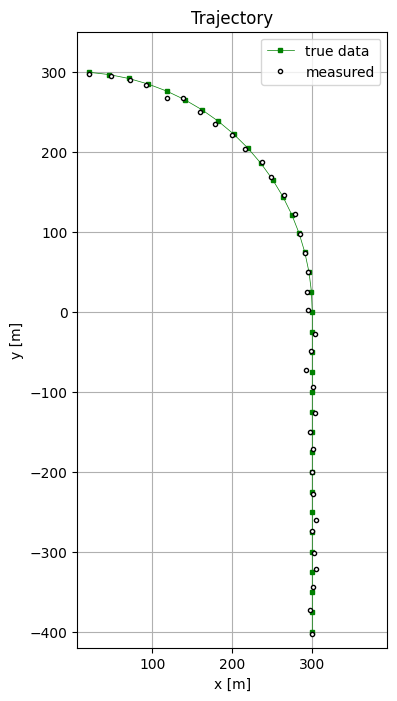

In [17]:
fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(4,8))

ax1.plot(xtrue, ytrue, color='g', marker='s', markersize=3, linestyle='-', linewidth=0.5, label='true data')
ax1.plot(r_vec*np.cos(phi_vec), r_vec*np.sin(phi_vec), color='k', marker='o', markersize=3, markerfacecolor='w', linestyle='', label='measured')
ax1.set_xlabel('x [m]')
ax1.set_ylabel('y [m]')
ax1.axis('equal')
ax1.set_title('Trajectory')
ax1.set_xlim(0, 400)
ax1.set_ylim(-420, 350)
ax1.legend()
ax1.grid(True)

---

For the tracking example we will use these parameters:

| parameter | value | description |
|-----------|-------|-------------|
| measurement interval | $\Delta t$ | 1.0 s |
| acceleration std dev | $\sigma_a$ | $0.2 \ [m/s^2]$ |
| range measurements std. dev. | $\sigma_r$ | $5 \ m$ |
| angle measurement error | $\sigma_{\varphi}$ | $0.0087 \ rad \approx  0.5 \ deg$ |

in the following sections of this notebook the computational steps from the initialisation to the first state estimate are shown. The approach is comparable to the numerical example of the book.

In [18]:
dt = 1.0
sigma_a =0.2
sigma_r = 5.0
sigma_phi = 0.0087

# state transition matrix
F_mat = np.array([[1, dt, 0.5*dt**2, 0, 0, 0],
                 [0, 1, dt, 0, 0, 0],
                 [0, 0, 1, 0, 0, 0],
                  [0, 0, 0, 1, dt, 0.5*dt**2],
                  [0, 0, 0, 0, 1, dt],
                  [0, 0, 0, 0, 0, 1] ])

# process noise matrix
Q_mat = (sigma_a**2) * np.array([[0.25*dt**4, 0.5*dt**3, 0.5*dt**2, 0, 0, 0],
                 [0.5*dt**3, dt**2, dt, 0, 0, 0],
                  [0.5*dt**2, dt, 1, 0, 0, 0],
                  [0, 0, 0, 0.25*dt**4, 0.5*dt**3, 0.5*dt**2],
                  [0, 0, 0, 0.5*dt**3, dt**2, dt],
                  [0, 0, 0, 0.5*dt**2, dt, 1] ])

R_mat = np.array([[sigma_r**2, 0],
                [0, sigma_phi**2] ])

print(f"F_mat :\n{F_mat}\n")
print(f"Q_mat :\n{Q_mat}\n")
print(f"R_mat :\n{R_mat}\n")

F_mat :
[[1.  1.  0.5 0.  0.  0. ]
 [0.  1.  1.  0.  0.  0. ]
 [0.  0.  1.  0.  0.  0. ]
 [0.  0.  0.  1.  1.  0.5]
 [0.  0.  0.  0.  1.  1. ]
 [0.  0.  0.  0.  0.  1. ]]

Q_mat :
[[0.01 0.02 0.02 0.   0.   0.  ]
 [0.02 0.04 0.04 0.   0.   0.  ]
 [0.02 0.04 0.04 0.   0.   0.  ]
 [0.   0.   0.   0.01 0.02 0.02]
 [0.   0.   0.   0.02 0.04 0.04]
 [0.   0.   0.   0.02 0.04 0.04]]

R_mat :
[[2.500e+01 0.000e+00]
 [0.000e+00 7.569e-05]]



**inital conditions**

The initial state vector $\mathbf{\hat{x}}_{0,0}$ is chosen like this:

$$
\mathbf{\hat{x}}_{0,0} = \left[\begin{array}{c}
400 \\ 0 \\ 0 \\ -300 \\ 0 \\ 0
\end{array}\right]
$$

For the covariance matrix $\mathbf{P}_{0,0}$ :

$$
\mathbf{P}_{0,0} = \left[\begin{array}{cccccc}
500 & 0 & 0 & 0 & 0 & 0 \\
0 & 500 & 0 & 0 & 0 & 0 \\
0 & 0 & 500 & 0 & 0 & 0 \\
0 & 0 & 0 & 500 & 0 & 0 \\
0 & 0 & 0 & 0 & 500 & 0 \\
0 & 0 & 0 & 0 & 0 & 500
\end{array}\right]
$$

In [19]:
x_init = 400.0
y_init = -300.0
var_p_init = 500.0

x_00_vec = np.array([x_init, 0, 0, y_init, 0, 0] )
P_00_mat = np.diag( [var_p_init]*6 )


print(f"x_00_vec:\n{x_00_vec}\n")
print(f"P_00_mat:\n{P_00_mat}\n")

x_00_vec:
[ 400.    0.    0. -300.    0.    0.]

P_00_mat:
[[500.   0.   0.   0.   0.   0.]
 [  0. 500.   0.   0.   0.   0.]
 [  0.   0. 500.   0.   0.   0.]
 [  0.   0.   0. 500.   0.   0.]
 [  0.   0.   0.   0. 500.   0.]
 [  0.   0.   0.   0.   0. 500.]]



**prediction step**

$$\begin{align}
\mathbf{\hat{x}}_{1,0} &= \mathbf{F} \cdot \mathbf{\hat{x}}_{0,0} \\
\mathbf{P}_{1,0} &= \mathbf{F} \cdot \mathbf{P}_{0,0}  \cdot \mathbf{F}^T + \mathbf{Q
\end{align}
$$

In [20]:
x_10_vec = F_mat @ x_00_vec
P_10_mat = F_mat @ P_00_mat @ F_mat.T + Q_mat

print(f"x_10_vec:\n{x_10_vec}\n")
print(f"P_10_mat:\n{P_10_mat}\n")

x_10_vec:
[ 400.    0.    0. -300.    0.    0.]

P_10_mat:
[[1125.01  750.02  250.02    0.      0.      0.  ]
 [ 750.02 1000.04  500.04    0.      0.      0.  ]
 [ 250.02  500.04  500.04    0.      0.      0.  ]
 [   0.      0.      0.   1125.01  750.02  250.02]
 [   0.      0.      0.    750.02 1000.04  500.04]
 [   0.      0.      0.    250.02  500.04  500.04]]



In [21]:
# first measurement
z_1_vec = z_vec[:,0]
print(f"z_1_vec:\n{z_1_vec}\n")

z_1_vec:
[502.55    -0.9316]



**observation vector**

$$
\mathbf{h}(\mathbf{\hat{x}}_{1,0}) =  \left[\begin{array}{c}
\sqrt{x_{1,0}^2 + y_{1,0}^2} \\
 arctan\left( \frac{y_{1,0}}{x_{1,0}}\right)
\end{array}\right] 
$$

**Jacobian matrix**

$$
\frac{\partial \mathbf{h(\hat{x}_{1,0})}}{\partial (\mathbf{x})} = \left[\begin{array}{cccccc}
\frac{x_{1,0}}{\sqrt{x_{1,0}^2 + y_{1,0}^2}} & 0 & 0 & \frac{y_{1,0}}{\sqrt{x_{1,0}^2 + y_{1,0}^2}} & 0 & 0 \\
\frac{-y_{1,0}}{x_{1,0}^2 + y_{1,0}^2} & 0 & 0 & \frac{x_{1,0}}{x_{1,0}^2 + y_{1,0}^2} & 0 & 0
\end{array}\right]
$$

In [22]:
x_10 = x_10_vec[0]
y_10 = x_10_vec[3]

# common denominator
denom = (x_10**2 + y_10**2)
sqrt_denom = math.sqrt(denom)

# observation vector
h_10_vec = np.array([sqrt_denom, math.atan2(y_10, x_10)])

# Jacobian matrix
J_10_mat = np.array([[x_10/sqrt_denom, 0, 0, y_10/sqrt_denom, 0, 0 ],
                   [-y_10/denom, 0, 0, x_10/denom, 0, 0 ] ])

print(f"h_10_vec:\n{h_10_vec}\n")
print(f"J_10_mat:\n{J_10_mat}\n")

h_10_vec:
[500.          -0.64350111]

J_10_mat:
[[ 0.8     0.      0.     -0.6     0.      0.    ]
 [ 0.0012  0.      0.      0.0016  0.      0.    ]]



**Kalman Gain**

$$
\mathbf{K_1} = \mathbf{P}_{1,0} \cdot \frac{\partial \mathbf{h(\hat{x}_{1,0})}}{\partial (\mathbf{x})}^T \cdot \left( \frac{\partial \mathbf{h(\hat{x}_{1,0})}}{\partial (\mathbf{x})} \cdot \mathbf{P}_{1,0} \cdot \frac{\partial \mathbf{h(\hat{x}_{1,0})}}{\partial (\mathbf{x})}^T + \mathbf{R}_1 \right)^{-1}
$$

In [23]:
K_1_mat = P_10_mat @ J_10_mat.T @ np.linalg.inv( J_10_mat @ P_10_mat @ J_10_mat.T  + R_mat)

print(f"K_1_mat:\n{K_1_mat}\n")

K_1_mat:
[[ 7.82608847e-01  2.95037513e+02]
 [ 5.21748507e-01  1.96695172e+02]
 [ 1.73925444e-01  6.55685541e+01]
 [-5.86956635e-01  3.93383351e+02]
 [-3.91311380e-01  2.62260230e+02]
 [-1.30444083e-01  8.74247388e+01]]



**current state estimate**

$$
\mathbf{\hat{x}_{1,1} } = \mathbf{\hat{x}_{1,0}} + \mathbf{K_1} \cdot \left(\mathbf{z_1} - h(\mathbf{\hat{x}_{1,0}})  \right)
$$

In [24]:
x_11_vec = x_10_vec + K_1_mat @ (z_1_vec - h_10_vec)

print(f"x_11_vec:\n{x_11_vec}")

x_11_vec:
[ 316.99567216  -55.33720231  -18.44671785 -414.83004662  -76.55472535
  -25.51960272]


**covariance estimate**

$$
\mathbf{P_{1,1}} = \left(\mathbf{I} - \mathbf{K_1} \cdot \frac{\partial \mathbf{h(\hat{x}_{1,0})}}{\partial (\mathbf{x})} \right) \cdot \mathbf{P}_{1,0} \cdot \left(\mathbf{I} - \mathbf{K_1} \cdot \frac{\partial \mathbf{h(\hat{x}_{1,0})}}{\partial (\mathbf{x})} \right)^T + \mathbf{K_1} \cdot \mathbf{R}_1 \cdot \mathbf{K_1}^T
$$

In [25]:
aux_mat = np.eye(6) - K_1_mat @ J_10_mat
P_11_mat = aux_mat @ P_10_mat @ aux_mat.T + K_1_mat @ R_mat @ K_1_mat.T

print(f"P_11_mat:\n{P_11_mat}\n")

P_11_mat:
[[ 2.23515937e+01  1.49013274e+01  4.96737404e+00 -2.80657696e+00
  -1.87108457e+00 -6.23728118e-01]
 [ 1.49013274e+01  5.09952172e+02  3.36668678e+02 -1.87108457e+00
  -1.24741189e+00 -4.15826138e-01]
 [ 4.96737404e+00  3.36668678e+02  4.45579988e+02 -6.23728118e-01
  -4.15826138e-01 -1.38616105e-01]
 [-2.80657696e+00 -1.87108457e+00 -6.23728118e-01  2.07144239e+01
   1.38098614e+01  4.60353264e+00]
 [-1.87108457e+00 -1.24741189e+00 -4.15826138e-01  1.38098614e+01
   5.09224516e+02  3.36426113e+02]
 [-6.23728118e-01 -4.15826138e-01 -1.38616105e-01  4.60353264e+00
   3.36426113e+02  4.45499129e+02]]



## Preliminary Summary

So far the numerical results are close to the values from the book. 

Now we are going to set up a program which computes results for all available measurements.

**Note**

The program is not part of the example provided by the book. So we cannot cross-check the results of the simulation. However from visual inspection of the results it seems that the results from the book and this program are very similar.

**Workflow**

1) The parameters used for initialisation are defined

2) The state transition matrix is computed

3) The covariance matrix of process noise is computed

4) The covariance matrix of measurement noise is computed

5) The inital position is defined. Here I have chosen the parameters from the book. I would have preferred to use the first measurement instead ...

6) The initial state vector and the initial covariance matrix of the system state are computed

7) Some auxiliary data structures are set up. Subsequent results will be stored in these data structures

8) All other computations are done in a loop. For each iteration step we compute:

   a) the predicted state (using the state transition matrix)

   b) the prediction / extrapolation of the covariance matrix

   c) the x, y position from the predicted state vector are used to compute the observation vector

   d) the Jacobian matrix is computed

   e) the Kalman gain is computed

   f) the current state estimate is computed

   g) the current estimate of the covariance matrix is computed

   h) results (state, covariance) of the current iteration are stored

9) computation finished, some post processing (trace of covariance matrix) are performed --> for graphics

---

In [26]:
nr, nm = z_vec.shape

# initialise matrix for estimated state vector ; each state vector shall be a row of this matrix
state_mat = np.zeros( (nm, 6) )

dt = 1.0
sigma_a = 0.2
sigma_r = 5.0
sigma_phi = 0.0087

# state transition matrix
F_mat = np.array([[1, dt, 0.5*dt**2, 0, 0, 0],
                 [0, 1, dt, 0, 0, 0],
                 [0, 0, 1, 0, 0, 0],
                  [0, 0, 0, 1, dt, 0.5*dt**2],
                  [0, 0, 0, 0, 1, dt],
                  [0, 0, 0, 0, 0, 1] ])

# process noise matrix
Q_mat = (sigma_a**2) * np.array([[0.25*dt**4, 0.5*dt**3, 0.5*dt**2, 0, 0, 0],
                 [0.5*dt**3, dt**2, dt, 0, 0, 0],
                  [0.5*dt**2, dt, 1, 0, 0, 0],
                  [0, 0, 0, 0.25*dt**4, 0.5*dt**3, 0.5*dt**2],
                  [0, 0, 0, 0.5*dt**3, dt**2, dt],
                  [0, 0, 0, 0.5*dt**2, dt, 1] ])

R_mat = np.array([[sigma_r**2, 0],
                [0, sigma_phi**2] ])

# initial conditions
x_init = 400.0
y_init = -300.0
var_p_init = 500.0

# initial state vector
x_est_vec = np.array([x_init, 0, 0, y_init, 0, 0] )
# initial state covariance matrix
P_est_mat = np.diag( [var_p_init]*6 )
variances = np.zeros( (nm, 6) )

for k in range(nm):
    # predict state
    x_pre_vec = F_mat @ x_est_vec
    # predict state covariance matrix
    P_pre_mat = F_mat @ P_est_mat @ F_mat.T + Q_mat

    # measurement
    z_m_vec = z_vec[:,k]
    
    # x- and y component of predicted state
    x_pre = x_pre_vec[0]
    y_pre = x_pre_vec[3]

    # common denominator
    denom = (x_pre**2 + y_pre**2)
    sqrt_denom = math.sqrt(denom)

    # observation vector
    h_vec = np.array([sqrt_denom, math.atan2(y_pre, x_pre)])

    # Jacobian matrix
    J_mat = np.array([[x_pre/sqrt_denom, 0, 0, y_pre/sqrt_denom, 0, 0 ],
                       [-y_pre/denom, 0, 0, x_pre/denom, 0, 0 ] ])

    # Kalman gain
    K_mat = P_pre_mat @ J_mat.T @ np.linalg.inv( J_mat @ P_pre_mat @ J_mat.T  + R_mat)

    # current state estimate
    x_est_vec = x_pre_vec + K_mat @ (z_m_vec - h_vec)

    # current estimate of state covariance
    aux_mat = np.eye(6) - K_mat @ J_mat
    P_est_mat = aux_mat @ P_pre_mat @ aux_mat.T + K_mat @ R_mat @ K_mat.T

    # store estimated state
    state_mat[k, :] = x_est_vec

    # store variances
    variances[k, :] = np.diag(P_est_mat)

# post processing of results

# sum of variances for each iteration 
trace_var = np.sum(variances, axis=1) 

# estimated positions (for graphics)
x_estimates = state_mat[:,0]
y_estimates = state_mat[:,3]

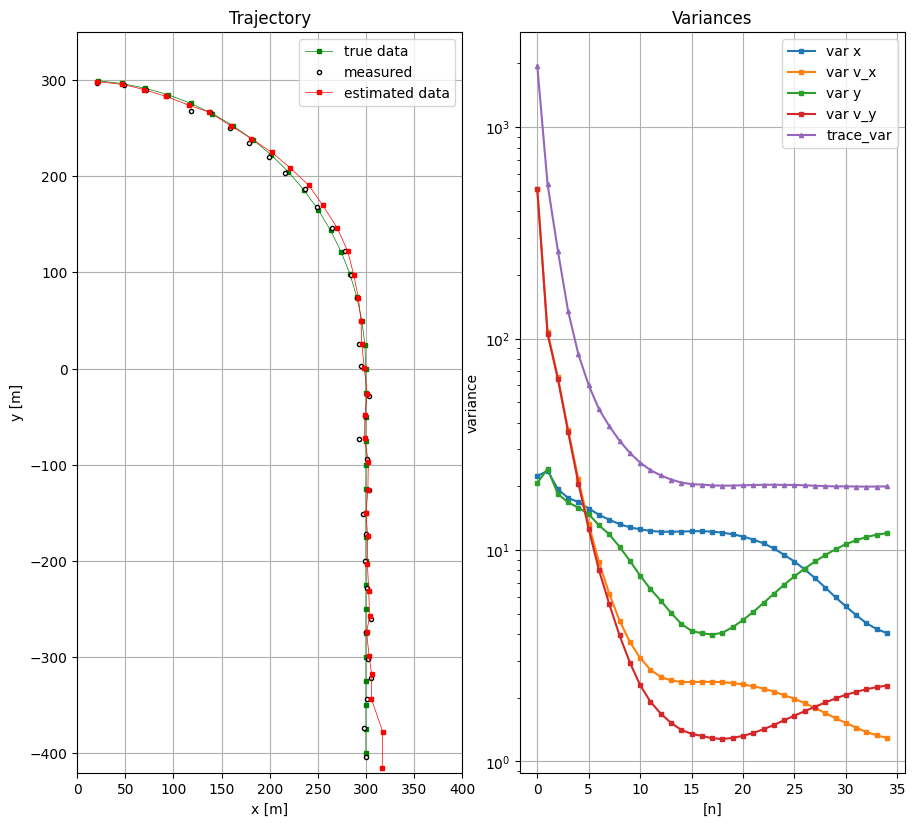

In [27]:
fig2, ax2 = plt.subplots(nrows=1, ncols=2, figsize=(9,8))

fig2.tight_layout()

ax2[0].plot(xtrue, ytrue, color='g', marker='s', markersize=3, linestyle='-', linewidth=0.5, label='true data')
ax2[0].plot(r_vec*np.cos(phi_vec), r_vec*np.sin(phi_vec), color='k', marker='o', markersize=3, markerfacecolor='w', linestyle='', label='measured')
ax2[0].plot(x_estimates, y_estimates, color='r', marker='s', markersize=3, linewidth=0.5, label='estimated data')
ax2[0].set_xlabel('x [m]')
ax2[0].set_ylabel('y [m]')
ax2[0].axis('equal')
ax2[0].set_title('Trajectory')
ax2[0].set_xlim(0, 400)
ax2[0].set_ylim(-420, 350)
ax2[0].legend()
ax2[0].grid(True)

ax2[1].semilogy(variances[:,0], marker='s', markersize=3, label='var x')
ax2[1].semilogy(variances[:,1], marker='s', markersize=3, label='var v_x')
ax2[1].semilogy(variances[:,3], marker='s', markersize=3, label='var y')
ax2[1].semilogy(variances[:,4], marker='s', markersize=3, label='var v_y')
ax2[1].semilogy(trace_var, marker='^', markersize=3, label='trace_var')
ax2[1].set_xlabel('[n]')
ax2[1].set_ylabel('variance')
ax2[1].set_title('Variances')
ax2[1].legend()
ax2[1].grid(True)

**Comments**

For each estimation step the diagonal elements of the covariance matrix $\mathbf{P}_{n,n}$ of state estimates are computed. The variances of position and velocity in x- and y direction are displayed on the right column of the figure.

As an overall indicator of the estimation process the trace of the covariance $trace\left(\mathbf{P}_{n,n}\right)$ is computed and displayed. The decay of $trace\left(\mathbf{P}_{n,n}\right)$ with successive iteration steps $n$ shows how the estimation process converges. (Note: The Kalman gain *minimises* the trace of the covariance ... )

---